In [1]:
import torch
import functools
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
from tqdm import tqdm
from models import UNet_Tranformer, AutoEncoder, Latent_UNet_Tranformer
from utils import marginal_prob_std, diffusion_coeff, Euler_Maruyama_sampler

## DDPM

/tmp/ipykernel_14241/3086108902.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load('model_objects/ckpt_mnist_ddpm_100e.pth', map_location=device)
100%|███

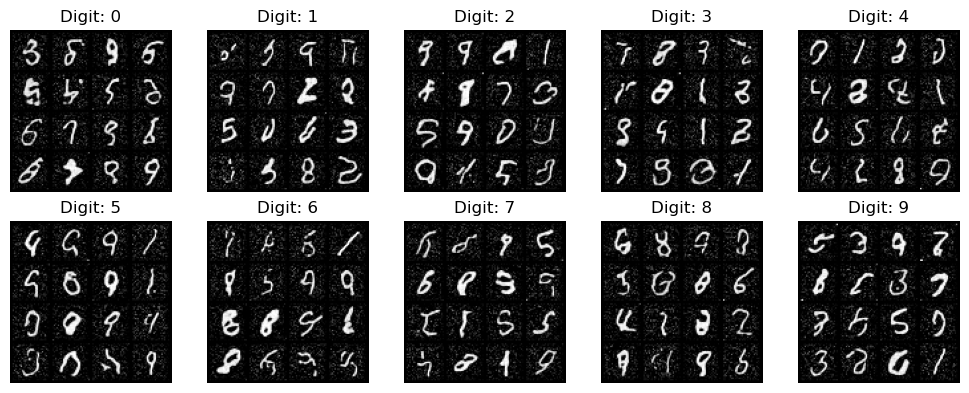

In [7]:
sigma =  25.0#@param {'type':'number'}

marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

# Load the pre-trained checkpoint from disk.
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}
ckpt = torch.load('model_objects/ckpt_mnist_ddpm_100e.pth', map_location=device)
score_model = torch.nn.DataParallel(UNet_Tranformer(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)
score_model.load_state_dict(ckpt)
score_model.eval()

# Set params
sample_batch_size = 16 #@param {'type':'integer'}
num_steps = 250 #@param {'type':'integer'}
sampler = Euler_Maruyama_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}

## Generate samples using the specified sampler.
%matplotlib inline
plt.figure(figsize=(10, 4))

for i, digit in enumerate(range(10)):
    samples = sampler(score_model,
            marginal_prob_std_fn,
            diffusion_coeff_fn,
            num_steps,
            sample_batch_size,
            device=device,
            y=digit*torch.ones(sample_batch_size, dtype=torch.long))

    ## Sample visualization.
    samples = samples.clamp(0.0, 1.0)
    sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

    plt.subplot(2, 5, i+1)
    plt.title(f"Digit: {digit}")
    plt.axis('off')
    plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)

plt.tight_layout()
plt.show()

## AutoEncoder

/tmp/ipykernel_9485/3188825694.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load('ckpt_mnist_ae_50e.pth', map_location=device)


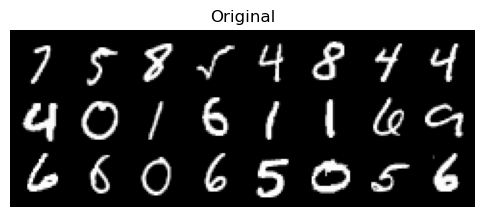

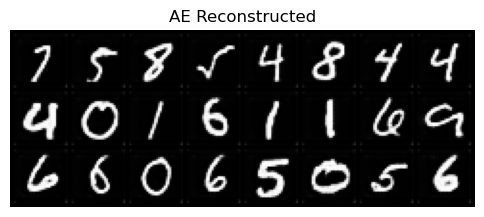

In [10]:
#@title Visualize trained autoencoder
# Load model
device = 'cuda'
ckpt = torch.load('ckpt_mnist_ae_50e.pth', map_location=device)
ae_model = AutoEncoder([4, 4, 4]).cuda()
ae_model = ae_model.to(device)
ae_model.load_state_dict(ckpt)
ae_model.eval()

# Prep dataloader
batch_size =  24
dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

# Get next batch
x, y = next(iter(data_loader))
x_hat = ae_model(x.to(device)).cpu()
plt.figure(figsize=(6,6.5))
plt.axis('off')
plt.imshow(make_grid(x[:64,:,:,:].cpu()).permute([1,2,0]), vmin=0., vmax=1.)
plt.title("Original")
plt.show()

plt.figure(figsize=(6,6.5))
plt.axis('off')
plt.imshow(make_grid(x_hat[:64,:,:,:].cpu()).permute([1,2,0]), vmin=0., vmax=1.)
plt.title("AE Reconstructed")
plt.show()

## LDM

/tmp/ipykernel_14241/1610307240.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load('model_objects/ckpt_mnist_ldm_3e4_2000e.pth', map_location=device)
/tmp

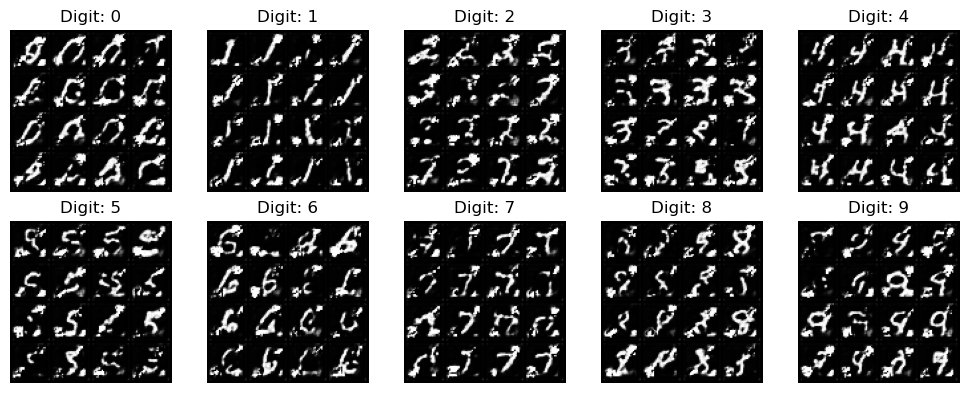

In [13]:
sigma =  25.0#@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

# Load latent diffusion model
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}
ckpt = torch.load('model_objects/ckpt_mnist_ldm_3e4_2000e.pth', map_location=device)
score_model = torch.nn.DataParallel(Latent_UNet_Tranformer(marginal_prob_std=marginal_prob_std_fn, channels = [4, 16, 32, 64]))
score_model = score_model.to(device)
score_model.load_state_dict(ckpt)
score_model.eval()

# Load autoencoder model
ae_ckpt = torch.load('model_objects/ckpt_mnist_ae_50e.pth', map_location=device)
ae_model = AutoEncoder([4, 4, 4]).cuda()
ae_model = ae_model.to(device)
ae_model.load_state_dict(ae_ckpt)
ae_model.eval()

# Set params
sample_batch_size = 16 #@param {'type':'integer'}
num_steps = 250 #@param {'type':'integer'}
sampler = Euler_Maruyama_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}

## Generate samples using the specified sampler.
%matplotlib inline
plt.figure(figsize=(10, 4))

for i, digit in enumerate(range(10)):
    samples = sampler(score_model,
            marginal_prob_std_fn,
            diffusion_coeff_fn,
            num_steps,
            sample_batch_size,
            device=device,
            x_shape=(4,10,10),
            y=digit*torch.ones(sample_batch_size, dtype=torch.long))

    ## Sample visualization.
    decoder_samples = ae_model.decoder(samples).clamp(0.0, 1.0)
    sample_grid = make_grid(decoder_samples, nrow=int(np.sqrt(sample_batch_size)))

    plt.subplot(2, 5, i+1)
    plt.title(f"Digit: {digit}")
    plt.axis('off')
    plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)

plt.tight_layout()
plt.show()